In [1]:
import seaborn as sns
from pyspark.sql import SparkSession, functions, Window

In [2]:
def get_session():
    return SparkSession \
        .builder \
        .appName('Market Analytics') \
        .getOrCreate()

In [3]:
sess = get_session()

## Overview datasets

In [4]:
!ls -l dataset/Stocks | head

total 686608
-rw-rw-r-- 1 faisal faisal  21911 Nov 13  2017 aaap.us.txt
-rw-rw-r-- 1 faisal faisal 246552 Nov 13  2017 aaba.us.txt
-rw-rw-r-- 1 faisal faisal  33723 Nov 13  2017 aac.us.txt
-rw-rw-r-- 1 faisal faisal  49499 Nov 13  2017 aal.us.txt
-rw-rw-r-- 1 faisal faisal  50642 Nov 13  2017 aamc.us.txt
-rw-rw-r-- 1 faisal faisal 135301 Nov 13  2017 aame.us.txt
-rw-rw-r-- 1 faisal faisal 155628 Nov 13  2017 aan.us.txt
-rw-rw-r-- 1 faisal faisal  46086 Nov 13  2017 aaoi.us.txt
-rw-rw-r-- 1 faisal faisal 154078 Nov 13  2017 aaon.us.txt
ls: write error: Broken pipe


In [5]:
!cat dataset/Stocks/aac.us.txt | head

In [6]:
!du -sh .

1,4G	.


## Load Datasets

In [7]:
@functions.udf
def extract_symbol(filename):
    return filename.split('/')[-1].split('.')[0]

def load_data(session):
    df = session.read.format('csv').option('header', 'true').load('dataset/Stocks/*.txt')
    df = df.drop('OpenInt')
    df = df.withColumn('Symbol', extract_symbol(functions.input_file_name()))
    df = df.withColumn('Date', df['Date'].cast('date'))
    df = df.withColumn('Open', df['Open'].cast('float'))
    df = df.withColumn('High', df['High'].cast('float'))
    df = df.withColumn('Low', df['Low'].cast('float'))
    df = df.withColumn('Close', df['Close'].cast('float'))
    return df

In [8]:
load = load_data(sess)
load.show(10)

+----------+------+------+------+------+-------+------+
|      Date|  Open|  High|   Low| Close| Volume|Symbol|
+----------+------+------+------+------+-------+------+
|1962-01-02|0.6277|0.6362|0.6201|0.6201|2575579|    ge|
|1962-01-03|0.6201|0.6201|0.6122|0.6201|1764749|    ge|
|1962-01-04|0.6201|0.6201|0.6037|0.6122|2194010|    ge|
|1962-01-05|0.6122|0.6122|0.5798|0.5957|3255244|    ge|
|1962-01-08|0.5957|0.5957|0.5716|0.5957|3696430|    ge|
|1962-01-09|0.5957|0.6037|0.5878|0.5957|2778285|    ge|
|1962-01-10|0.5957|0.6037|0.5957|0.5957|2337096|    ge|
|1962-01-11|0.5957|0.5957|0.5878|0.5957|1943605|    ge|
|1962-01-12|0.5957|0.6037|0.5878|0.5878|2015151|    ge|
|1962-01-15|0.5957|0.5957|0.5957|0.5957|2527879|    ge|
+----------+------+------+------+------+-------+------+
only showing top 10 rows



## Technical Indicator

### Simple Moving Average

A simple moving average (SMA) is an arithmetic moving average calculated by adding recent closing prices and then dividing that by the number of time periods in the calculation average. A simple, or arithmetic, moving average that is calculated by adding the closing price of the security for a number of time periods and then dividing this total by that same number of periods. Short-term averages respond quickly to changes in the price of the underlying, while long-term averages are slow to react.

$$SMA = \frac{A_1 + A_2 + ... + A_n}{n}$$

where:

$A_n$ = the price of an asset at period $n$

$n$ = the number of total periods

https://www.investopedia.com/terms/s/sma.asp

In [9]:
days = lambda i: i * 86400 

def simple_moving_average(df, symbol, day):
    df = df.where(df['Symbol'] == symbol.lower())

    w = Window()\
         .orderBy(functions.unix_timestamp(df['Date']))\
         .rangeBetween(-days(day), 0)
    
    df = df.withColumn('SMA', functions.avg('Close').over(w))

    return df.select('Date', 'Close', 'SMA')

In [10]:
# moving average 100, symbol aapl (Apple)
aapl = simple_moving_average(load, 'aapl', 100)
aapl.show(5)

+----------+-------+-------------------+
|      Date|  Close|                SMA|
+----------+-------+-------------------+
|1984-09-07|0.42388|  0.423880010843277|
|1984-09-10|0.42134|0.42260999977588654|
|1984-09-11|0.42902|0.42474666237831116|
|1984-09-12|0.41618|  0.422605000436306|
|1984-09-13|0.43927| 0.4259379982948303|
+----------+-------+-------------------+
only showing top 5 rows



In [11]:
def graph_sma(df):
    sns.lineplot(data=df, palette="tab10", linewidth=2.5)

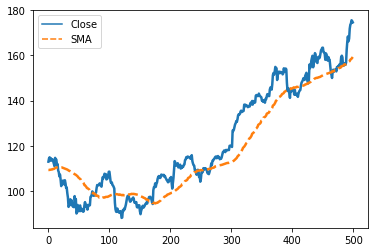

In [12]:
pandas = aapl.select('Close', 'SMA')\
    .orderBy(aapl['Date'].desc())\
    .limit(500)\
    .orderBy(aapl['Date'])\
    .toPandas()

graph_sma(pandas)

### Relative Strength Index

The relative strength index (RSI) is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. The indicator was originally developed by J. Welles Wilder Jr. and introduced in his seminal 1978 book, New Concepts in Technical Trading Systems.

In [13]:
def rsi(df, symbol, day):
    df = df.where(df['Symbol'] == symbol.lower())
    
    w = Window().orderBy(functions.unix_timestamp(df['Date']))
    
    # Index
    df = df.withColumn(
        'Index',
        functions.row_number().over(w) - 1
    )

    # Calculate change
    df = df.withColumn(
        'Change',
        
        functions.when(
            df['Index'] > 0,
            df['Close'] - functions.lag('Close', 1, 0).over(w)
        )
    )
    
    # Calculate advance
    df = df.withColumn(
        'Increase', 
        functions.when(
            df['Change'] > 0, 
            df['Change']
        )
    )
    
    # Calculate decline
    df = df.withColumn(
        'Decrease',
        functions.when(
            df['Change'] < 0, 
            df['Change'] * -1
        )
    )
    
    w_date = w.rowsBetween(-days(day), Window.currentRow)
    
    # Calculate average Gain
    df = df.withColumn(
        'AvgGain',
        functions.when(
            df['Index'] >= day,
            functions.sum('Increase').over(w_date) / day
        )
    )
    
    # Calculate average Loss
    df = df.withColumn(
        'AvgLoss',
        functions.when(
            df['Index'] >= day,
            functions.sum('Decrease').over(w_date) / day
        )
    )
    
    # Calculate RS
    df = df.withColumn(
        'RS',
        functions.when(
            df['Index'] == day,
            df['AvgGain'] / df['AvgLoss']
        ).otherwise(
            
            # smoothed RS
            (
                (((functions.lag('AvgGain', 1, 0).over(w) * (day - 1)) + 0.00) / day) / 
                (((functions.lag('AvgLoss', 1, 0).over(w) * (day - 1)) + 1.00) / day)
            )
        )
    )
    
    # calculate RSI
    df = df.withColumn(
        'RSI',
        100 - 100 / (1 + df['RS'])
    )
    return df

In [14]:
aapl = rsi(load, 'aapl', 14)
aapl = aapl.select(
    'Index', 'Close', 'Change', 'Increase', 'Decrease', 'AvgGain', 'AvgLoss', 'RS', 'RSI'
).limit(20).toPandas().replace(0).fillna('')

In [15]:
aapl.replace(0, '').fillna('')

,Index,Close,Change,Increase,Decrease,AvgGain,AvgLoss,RS,RSI
0,,0.42388,,,,,,,
1,1,0.42134,-0.00254002,,0.00254002,,,,
2,2,0.42902,0.00768,0.00768,,,,,
3,3,0.41618,-0.01284,,0.01284,,,,
4,4,0.43927,0.02309,0.02309,,,,,
5,5,0.44566,0.00639001,0.00639001,,,,,
6,6,0.45718,0.01152,0.01152,,,,,
7,7,0.44052,-0.01666,,0.01666,,,,
8,8,0.43157,-0.00895,,0.00895,,,,
9,9,0.43286,0.00128999,0.00128999,,,,,
